In [2]:
rm(list=ls())
library("FactoMineR")
library("factoextra")
library(GSEABase)
library(GSVA)
library(clusterProfiler)
library(genefu)
library(ggplot2)
library(ggpubr)
library(hgu133plus2.db)
library(limma)
library(org.Hs.eg.db)
library(pheatmap)
library(stringr)
library(devtools) 
library(TCGAbiolinks)
library(survival)
library(survminer)

In [3]:
dir()

[1] "学徒作业_TCGA"                        
 [2] "学徒作业_TCGA.html"                   
 [3] "学徒作业_TCGA.ipynb"                  
 [4] "学徒作业_TCGA.zip"                    
 [5] "all_samples_PCA.png"                  
 [6] "anno_DEG.Rdata"                       
 [7] "clinic.csv"                           
 [8] "COADREAD_clinic.csv"                  
 [9] "COADREAD_clinic.txt"                  
[10] "COADREAD_exp.txt"                     
[11] "COADREAD_survival.csv"                
[12] "COADREAD_survival.txt"                
[13] "coding.csv"                           
[14] "cor_all.png"                          
[15] "cor_top500.png"                       
[16] "deg.csv"                              
[17] "gsea_results.Rdata"                   
[18] "heatmap_top200_DEG.png"               
[19] "kegg_and_go_up_and_down.R"            
[20] "MA.png"                               
[21] "msigdb_v7.0_files_to_download_locally"
[22] "msigdb.v7.0.symbols.gmt"              
[23] "step1-output.Rdata"                   
[24] "volcano.png"

## 导入数据

In [623]:
expset=as.data.frame(read.table('COADREAD_exp.txt',header = T, row.names = 1))

##### 如果直接导入R，则样本名中的“_”会被“.”所替换

##### 所以需要列名处理一下

In [624]:
t=str_split(colnames(expset),'\\.',simplify = T) 
colnames(expset)=paste(t[,1],t[,2],t[,3],t[,4],sep = '-')

In [625]:
head(expset)

,TCGA-CA-5256-01,TCGA-AZ-6599-01,TCGA-AA-3655-01,TCGA-A6-6137-01,TCGA-CK-4952-01,TCGA-A6-5657-01,TCGA-AD-6963-01,TCGA-AA-3663-11,TCGA-A6-6138-01,TCGA-A6-A567-01,⋯,TCGA-CI-6620-01,TCGA-AG-3725-01,TCGA-AH-6643-01,TCGA-DY-A0XA-01,TCGA-AF-3400-11,TCGA-EI-6506-01,TCGA-AF-2692-11,TCGA-AF-A56K-01,TCGA-DC-6154-01,TCGA-AG-3592-01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARHGEF10L,10.1616,11.1212,11.0245,11.0576,10.5660,10.4189,10.8635,11.0543,10.3716,11.5113,⋯,10.9090,11.2637,10.3559,10.4947,11.4043,11.3188,10.7338,10.7196,11.3442,10.7753
HIF3A,3.7172,2.3437,2.0858,6.0759,1.9506,5.4777,4.4634,8.4492,1.8943,4.7474,⋯,3.3234,1.4272,2.3162,3.1015,5.7645,3.0008,7.7070,6.7224,6.1021,5.0876
RNF17,0.0000,0.0000,0.5495,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
RNF10,10.4857,11.6878,11.5062,11.7053,11.8684,11.4861,11.4397,11.9238,11.7580,11.4303,⋯,11.3939,12.0311,11.6253,11.3194,12.1388,11.5119,11.8789,11.1103,11.5538,11.3385
RNF11,10.5157,10.3830,9.9334,10.2443,9.8537,10.1777,9.3104,11.0780,10.4115,10.6953,⋯,9.6838,10.3410,10.1512,9.8840,10.4810,9.9720,11.2593,9.6058,9.7442,9.2784
RNF13,11.1805,9.9166,9.6560,10.2250,9.9356,9.2937,9.6805,10.1588,10.3127,10.3167,⋯,10.1951,9.9082,10.2650,10.2442,9.8812,9.9949,10.2715,9.9048,10.2686,10.1770


In [626]:
clinic=as.data.frame(read.csv('clinic.csv',header = T))


In [627]:
survival_table=as.data.frame(read.csv('COADREAD_survival.csv',header = T))

In [628]:
cat('表达谱样本数: ',dim(expset)[2],sep='\n')
cat('临床信息样本数: ',dim(clinic)[1],sep='\n')
cat('生存信息样本数: ',dim(survival_table)[1],sep='\n')


表达谱样本数: 
434
临床信息样本数: 
733
生存信息样本数: 
728


In [629]:
a = colnames(expset)
b = clinic$ID
c = intersect(b,a)
ix = c
length(c)
rownames(clinic)=clinic$ID
rownames(survival_table)=survival_table$sample

[1] 431

##### 多一个？？？

##### 信息提取

In [630]:
clinic = clinic[c,]
expset = expset[,c]

In [631]:
head(clinic)

,ID,patient,age,days_to_last_followup,gender,pathologic_stage,sample_type,total_mutation,tumor_tissue_site,venous_invasion,vial_number,vital_status
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
TCGA-3L-AA1B-01,TCGA-3L-AA1B-01,TCGA-3L-AA1B,61,475,0,Stage I,1,NA,Colon,NO,A,0
TCGA-4N-A93T-01,TCGA-4N-A93T-01,TCGA-4N-A93T,67,146,1,Stage IIIB,1,NA,Colon,NO,,0
TCGA-4T-AA8H-01,TCGA-4T-AA8H-01,TCGA-4T-AA8H,42,385,0,Stage IIA,1,NA,Colon,NO,A,0
TCGA-5M-AAT4-01,TCGA-5M-AAT4-01,TCGA-5M-AAT4,74,,1,Stage IV,1,NA,Colon,YES,A,1
TCGA-5M-AAT5-01,TCGA-5M-AAT5-01,TCGA-5M-AAT5,NA,,NA,,1,NA,,,A,NA
TCGA-5M-AAT6-01,TCGA-5M-AAT6-01,TCGA-5M-AAT6,40,,0,Stage IV,1,NA,Colon,YES,A,1


In [632]:
group_list=clinic$sample_type

## check一下

[1] 20530   431

[1] 18932   431

[1] 18932   431

[1] 500 431

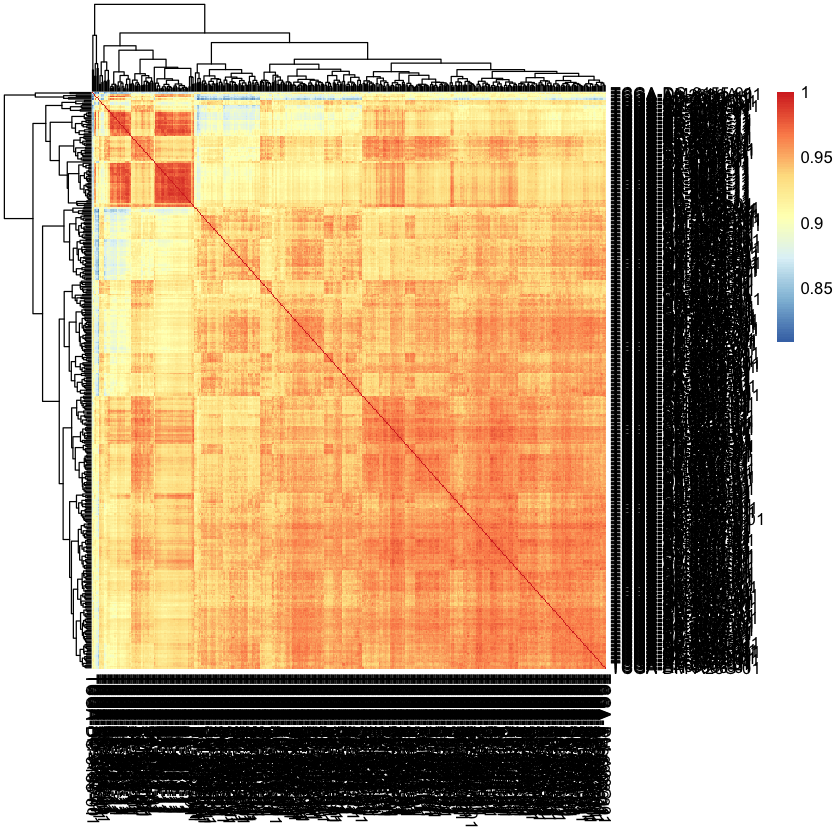

In [633]:
dat=expset
exprSet=dat
pheatmap::pheatmap(cor(exprSet)) 
# 组内的样本的相似性应该是要高于组间的！
colD=data.frame(group_list=group_list)
rownames(colD)=colnames(exprSet)
pheatmap::pheatmap(cor(exprSet),
                   annotation_col = colD,
                   show_rownames = F,
                   filename = 'cor_all.png')
dim(exprSet)
exprSet=exprSet[apply(exprSet,1, function(x) sum(x>1) > 5),]
dim(exprSet)

exprSet=log(edgeR::cpm(exprSet)+1)
dim(exprSet)
exprSet=exprSet[names(sort(apply(exprSet, 1,mad),decreasing = T)[1:500]),]
dim(exprSet)
M=cor(log2(exprSet+1)) 
pheatmap::pheatmap(M,annotation_col = colD)
pheatmap::pheatmap(M,
                   show_rownames = F,
                   annotation_col = colD,
                   filename = 'cor_top500.png')


In [561]:
group_list = clinic$pathologic_stage

In [563]:
table(group_list)
# 每次都要检测数据
dat[1:4,1:4]
## 下面是画PCA的必须操作，需要看说明书。
dat=t(dat)#画PCA图时要求是行名时样本名，列名时探针名，因此此时需要转换
dat=as.data.frame(dat)#将matrix转换为data.frame
dat=cbind(dat,group_list) #cbind横向追加，即将分组信息追加到最后一列
library("FactoMineR")#画主成分分析图需要加载这两个包
library("factoextra") 
# The variable group_list (index = 54676) is removed
# before PCA analysis
dat.pca <- PCA(dat[,-ncol(dat)], graph = FALSE)#现在dat最后一列是group_list，需要重新赋值给一个dat.pca,这个矩阵是不含有分组信息的



group_list
              [Discrepancy]       Stage I      Stage IA      Stage II 
           16             7            64             1            29 
    Stage IIA     Stage IIB     Stage IIC     Stage III    Stage IIIA 
          122             7             2            12            10 
   Stage IIIB    Stage IIIC      Stage IV     Stage IVA     Stage IVB 
           63            37            35            24             2 

,TCGA-3L-AA1B-01,TCGA-4N-A93T-01,TCGA-4T-AA8H-01,TCGA-5M-AAT4-01
,<dbl>,<dbl>,<dbl>,<dbl>
ARHGEF10L,11.3770,10.9172,11.2497,10.5722
HIF3A,5.5527,5.1237,3.2889,2.1513
RNF17,0.0000,0.0000,0.0000,0.5163
RNF10,11.7065,11.7262,11.9080,11.4311


In [564]:
dat$group_list

[1] 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1
 [38] 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0
 [75] 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1
[149] 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1
[186] 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[260] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[297] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[334] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
[371] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[408] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Saving 7 x 7 in image



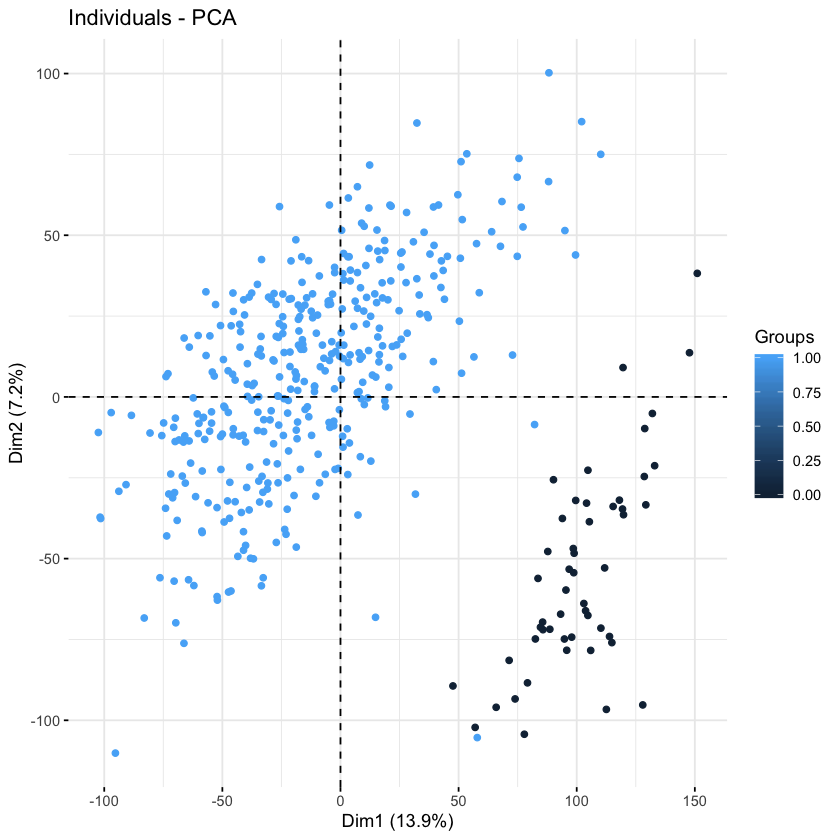

In [566]:
fviz_pca_ind(dat.pca,
             geom.ind = "point", # show points only (nbut not "text")
             col.ind = dat$group_list, # color by groups
             # palette = c("#00AFBB", "#E7B800"),
             addEllipses = F, # Concentration ellipses
             legend.title = "Groups"
)
ggsave('all_samples_PCA.png')

## limma 分析

In [763]:
bp=function(g){         #定义一个函数g，函数为{}里的内容
  library(ggpubr)
  df=data.frame(gene=g,stage=group_list)
  p <- ggboxplot(df, x = "stage", y = "gene",
                 color = "stage", palette = "jco",
                 add = "jitter")
  #  Add p-value
  p + stat_compare_means()
}

,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1


,tumor-normal
normal,-1
tumor,1


Warning message:
“Zero sample variances detected, have been offset away from zero”


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDH3,6.247058,10.0243842,44.46168,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006429723,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001320022,361.6275
OTOP2,-9.367759,1.9088174,-44.32969,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000018373693,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001886060,360.5861
AADACL2,-2.715070,0.4018283,-41.26910,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001221240260122650756,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000083573541801060062,335.8567
KRT80,6.612054,8.6982102,39.09479,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000118079850736016012356912434,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006060448339026021892942039,317.5952
DHRS7C,-2.841467,0.4441800,-39.05110,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000171885964070947853432187579,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000007057637684753118616106286,317.2222
OTOP3,-4.492609,0.7197856,-38.74390,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002423773415299807124256446608,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082933447026841726274763594,314.5930


The following object is masked _by_ .GlobalEnv:

    t


The following objects are masked from nrDEG (pos = 3):

    adj.P.Val, AveExpr, B, logFC, P.Value, t


The following objects are masked from nrDEG (pos = 4):

    adj.P.Val, AveExpr, B, logFC, P.Value, t


The following objects are masked from nrDEG (pos = 5):

    adj.P.Val, AveExpr, B, logFC, P.Value, t


The following objects are masked from nrDEG (pos = 6):

    adj.P.Val, AveExpr, B, logFC, P.Value, t


Saving 7 x 7 in image

Saving 7 x 7 in image



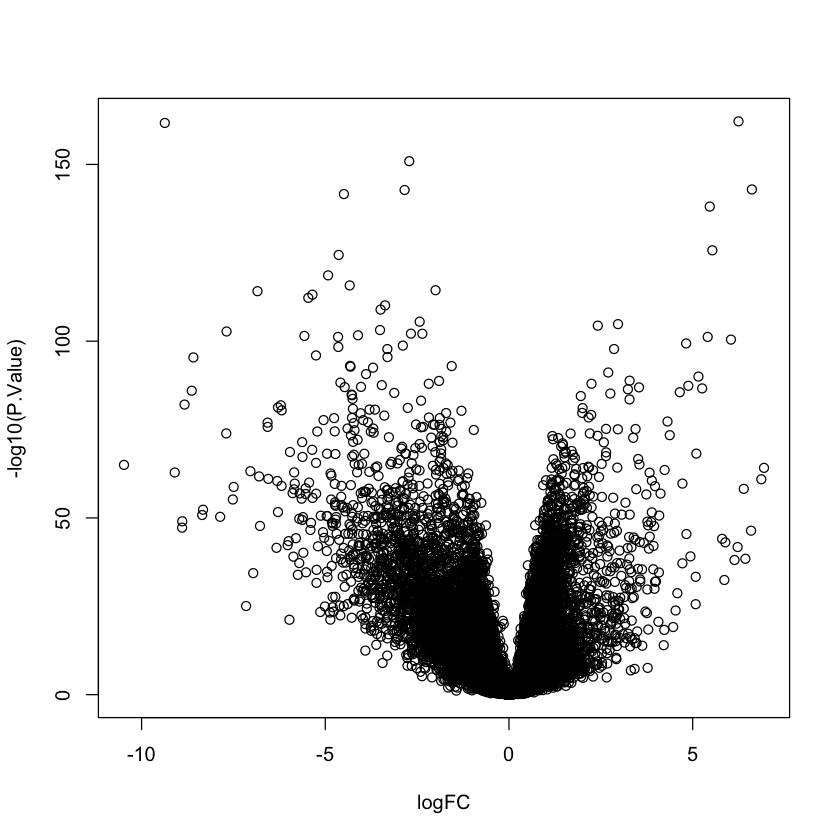

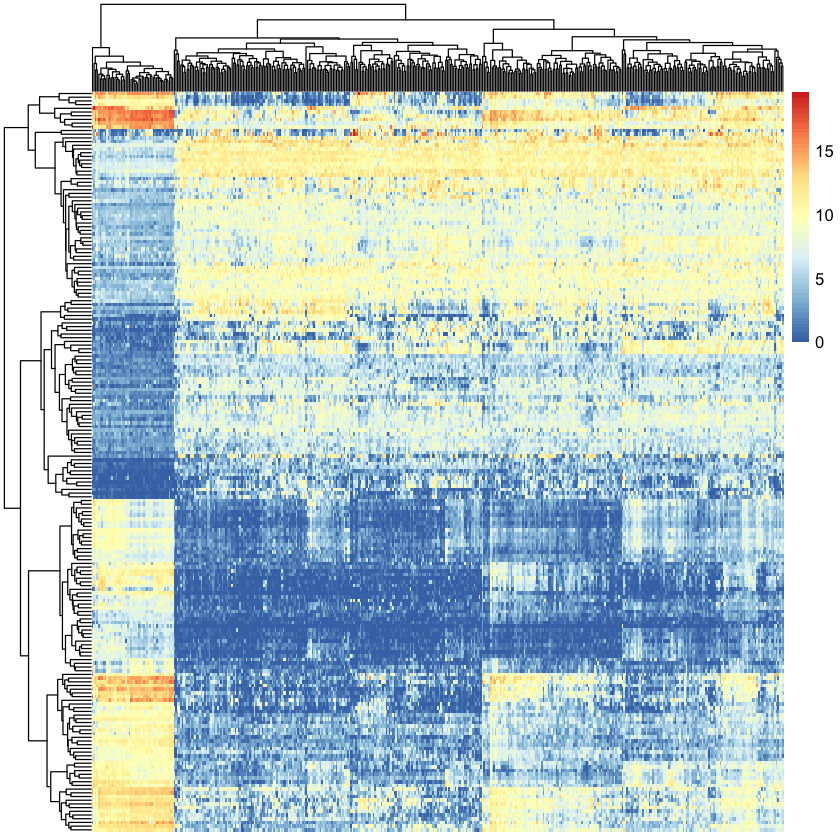

In [765]:
#limma
group_list=clinic$sample_type
design <- model.matrix(~0+factor(group_list))
colnames(design)=levels(factor(group_list))
head(design)
dat=expset
exprSet=dat
rownames(design)=colnames(exprSet)
colnames(design)=c('normal','tumor')
contrast.matrix<-makeContrasts("tumor-normal",
                               levels = design)
contrast.matrix ##这个矩阵声明，我们要把 Tumor 组跟 Normal 进行差异分析比较

deg = function(exprSet,design,contrast.matrix){
  ##step1
  fit <- lmFit(exprSet,design)
  ##step2
  fit2 <- contrasts.fit(fit, contrast.matrix) 
  ##这一步很重要，大家可以自行看看效果
  
  fit2 <- eBayes(fit2)  ## default no trend !!!
  ##eBayes() with trend=TRUE
  ##step3
  tempOutput = topTable(fit2, coef=1, n=Inf)
  nrDEG = na.omit(tempOutput) 
  #write.csv(nrDEG2,"limma_notrend.results.csv",quote = F)
  head(nrDEG)
  return(nrDEG)
}

deg = deg(exprSet,design,contrast.matrix)

head(deg)
## for volcano 
if(T){
  nrDEG=deg
  head(nrDEG)
  attach(nrDEG)
  plot(logFC,-log10(P.Value))
  library(ggpubr)
  df=nrDEG
  df$v= -log10(P.Value) #df新增加一列'v',值为-log10(P.Value)
  ggscatter(df, x = "logFC", y = "v",size=0.5)
  
  df$g=ifelse(df$P.Value>0.01,'stable', #if 判断：如果这一基因的P.Value>0.01，则为stable基因
              ifelse( df$logFC >2,'up', #接上句else 否则：接下来开始判断那些P.Value<0.01的基因，再if 判断：如果logFC >1.5,则为up（上调）基因
                      ifelse( df$logFC < -2,'down','stable') )#接上句else 否则：接下来开始判断那些logFC <1.5 的基因，再if 判断：如果logFC <1.5，则为down（下调）基因，否则为stable基因
  )
  table(df$g)
  df$name=rownames(df)
  head(df)
  ggscatter(df, x = "logFC", y = "v",size=0.5,color = 'g')
  ggscatter(df, x = "logFC", y = "v", color = "g",size = 0.5,
            label = "name", repel = T,
            #label.select = rownames(df)[df$g != 'stable'] ,
            label.select = c('TTC9', 'AQP3', 'CXCL11','PTGS2'), #挑选一些基因在图中显示出来
            palette = c("#00AFBB", "#E7B800", "#FC4E07") )
  ggsave('volcano.png')
  
  ggscatter(df, x = "AveExpr", y = "logFC",size = 0.2)
  df$p_c = ifelse(df$P.Value<0.001,'p<0.001',
                  ifelse(df$P.Value<0.01,'0.001<p<0.01','p>0.01'))
  table(df$p_c )
  ggscatter(df,x = "AveExpr", y = "logFC", color = "p_c",size=0.2, 
            palette = c("green", "red", "black") )
  ggsave('MA.png')
  
  
}

## for heatmap 
if(T){ 
  load(file = 'step1-output.Rdata')
  # 每次都要检测数据
  dat[1:4,1:4]
  table(group_list)
  x=deg$logFC #deg取logFC这列并将其重新赋值给x
  names(x)=rownames(deg) #deg取probe_id这列，并将其作为名字给x
  cg=c(names(head(sort(x),100)),#对x进行从小到大排列，取前100及后100，并取其对应的探针名，作为向量赋值给cg
       names(tail(sort(x),100)))
  library(pheatmap)
  pheatmap(dat[cg,],show_colnames =F,show_rownames = F) #对dat按照cg取行，所得到的矩阵来画热图
  n=t(scale(t(dat[cg,])))#通过“scale”对log-ratio数值进行归一化，现在的dat是行名为探针，列名为样本名，由于scale这个函数应用在不同组数据间存在差异时，需要行名为样本，因此需要用t(dat[cg,])来转换，最后再转换回来
  
  n[n>2]=2
  n[n< -2]= -2
  n[1:4,1:4]
  pheatmap(n,show_colnames =F,show_rownames = F)
  ac=data.frame(g=group_list)
  rownames(ac)=colnames(n) #将ac的行名也就分组信息（是‘no TNBC’还是‘TNBC’）给到n的列名，即热图中位于上方的分组信息
  pheatmap(n,show_colnames =F,
           show_rownames = F,
          cluster_cols = F, 
           annotation_col=ac,filename = 'heatmap_top200_DEG.png') #列名注释信息为ac即分组信息
  
  
}

write.csv(deg,file = 'deg.csv')















In [635]:
table(design[,1])


  0   1 
380  51 

In [766]:
deg[grep("APOC1",rownames(deg)),]

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
APOC1,0.5865535,7.9814548,2.363067,0.01856854,0.02718672,-4.978582
APOC1P1,0.1121036,0.1606267,2.066656,0.03936462,0.05518303,-5.627976


##### 提取载脂蛋白1分析信息，发现并没有统计学意义锕。

## 试一下edgr

In [ ]:
 library(edgeR)
  d <- DGEList(counts=exprSet,group=factor(group_list))
  keep <- rowSums(cpm(d)>1) >= 2
  table(keep)
  d <- d[keep, , keep.lib.sizes=FALSE]
  d$samples$lib.size <- colSums(d$counts)
  d <- calcNormFactors(d)
  d$samples
  dge=d
  design <- model.matrix(~0+factor(group_list))
  rownames(design)<-colnames(dge)
  colnames(design)<-levels(factor(group_list))
  dge=d
  dge <- estimateGLMCommonDisp(dge,design)
  dge <- estimateGLMTrendedDisp(dge, design)
  dge <- estimateGLMTagwiseDisp(dge, design)
  
  fit <- glmFit(dge, design)
  # https://www.biostars.org/p/110861/
  lrt <- glmLRT(fit,  contrast=c(-1,1)) 
  nrDEG=topTags(lrt, n=nrow(dge))
  nrDEG=as.data.frame(nrDEG)
  head(nrDEG)
  edgeR_DEG =nrDEG 
  nrDEG=edgeR_DEG[,c(1,5)]
  colnames(nrDEG)=c('log2FoldChange','pvalue') 

In [371]:
nrDEG[grep("APOC1",rownames(nrDEG)),]

,log2FoldChange,pvalue
,<dbl>,<dbl>
APOC1P1,0.6810794,0.09557798
APOC1,0.1152213,0.28297691


##### 还是一样，并没有统计显著性

## 尝试提取APOC1表达直接用T检验

##### 提取正常样本和疾病样本

In [570]:
normal=rownames(clinic)[which(clinic$sample_type==0)]
tumor=rownames(clinic)[which(clinic$sample_type!=0)]

In [571]:
n=expset[,normal]
t=expset[,tumor]
dim(n)
dim(t)

[1] 20530    51

[1] 20530   380

In [572]:
n1=n['APOC1',]
t1=t['APOC1',]

In [573]:
t.test(n1,t1)


	Welch Two Sample t-test

data:  n1 and t1
t = -3.0985, df = 80.725, p-value = 0.002676
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9632261 -0.2098809
sample estimates:
mean of x mean of y 
 7.464308  8.050861 


##### 结果表明具有统计显著性

##### 绘制差异箱形图

In [574]:
dim(expset)

[1] 20530   431

In [575]:
t1

,TCGA-3L-AA1B-01,TCGA-4N-A93T-01,TCGA-4T-AA8H-01,TCGA-5M-AAT4-01,TCGA-5M-AAT5-01,TCGA-5M-AAT6-01,TCGA-5M-AATA-01,TCGA-5M-AATE-01,TCGA-A6-2675-01,TCGA-A6-2682-01,⋯,TCGA-QG-A5YV-01,TCGA-QG-A5YW-01,TCGA-QG-A5YX-01,TCGA-QG-A5Z1-01,TCGA-QG-A5Z2-01,TCGA-QL-A97D-01,TCGA-RU-A8FL-01,TCGA-SS-A7HO-01,TCGA-T9-A92H-01,TCGA-WS-AB45-01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
APOC1,5.823,6.1723,4.4727,7.403,5.9035,10.7038,6.9151,5.8229,9.9415,7.6001,⋯,7.1488,8.9101,6.4819,8.1684,7.7032,5.9637,6.1939,4.8721,6.5477,7.8624


In [576]:
dat = rbind(t(n1),t(t1))
dat = cbind(dat,rep(1,431))
dat[1:51,2] = 0

In [577]:
colnames(dat) = c('APOC1','Type')
dat = as.data.frame(dat)
dat[,2]=ifelse(dat[,2]==1,'tumor','normal')

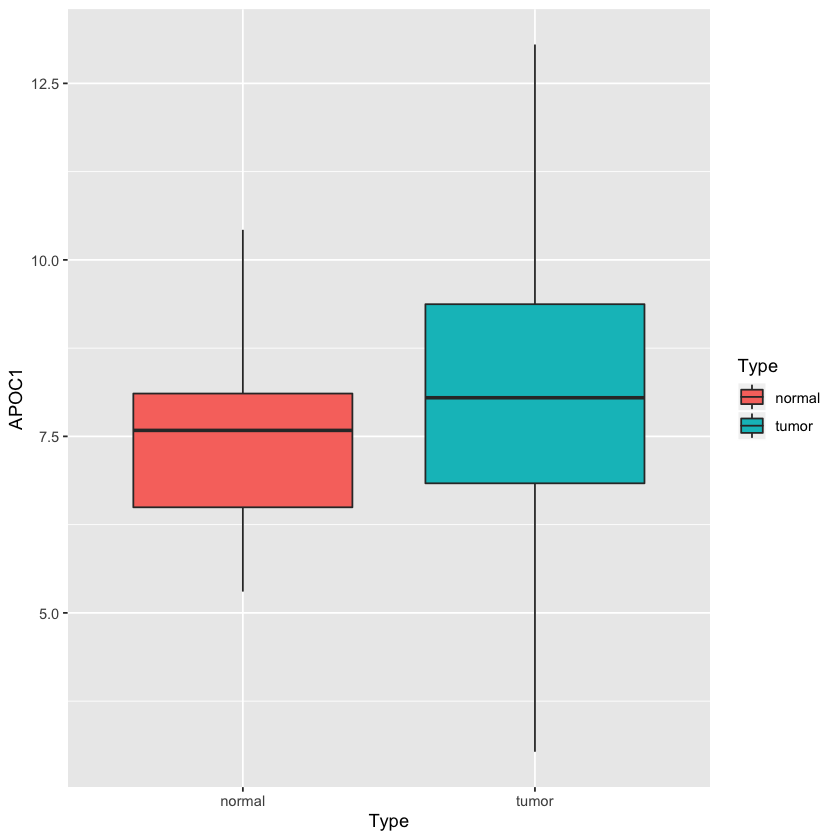

In [578]:
p<-ggplot(data=dat, aes(x=Type,y=APOC1))+geom_boxplot(aes(fill=Type))
p

##### 可以看出表达量确实有差异

## 配对T检验

In [579]:
clinic[10:20,1:5]

,ID,patient,age,days_to_last_followup,gender
,<fct>,<fct>,<int>,<fct>,<int>
TCGA-A6-2675-01,TCGA-A6-2675-01,TCGA-A6-2675,78,1321,1
TCGA-A6-2675-11,TCGA-A6-2675-11,TCGA-A6-2675,78,1321,1
TCGA-A6-2678-11,TCGA-A6-2678-11,TCGA-A6-2678,43,1286,0
TCGA-A6-2679-11,TCGA-A6-2679-11,TCGA-A6-2679,73,1366,0
TCGA-A6-2680-11,TCGA-A6-2680-11,TCGA-A6-2680,72,1068,0
TCGA-A6-2682-01,TCGA-A6-2682-01,TCGA-A6-2682,70,,1
TCGA-A6-2682-11,TCGA-A6-2682-11,TCGA-A6-2682,70,,1
TCGA-A6-2683-11,TCGA-A6-2683-11,TCGA-A6-2683,57,472,0
TCGA-A6-2684-01,TCGA-A6-2684-01,TCGA-A6-2684,75,1127,0


##### 可以看出，这里的ID和patient列中，ID列比pation多一位，注意到ID列中有11和01所对应的pation相同，更重要的是他们的type不同。因此可以推断，这些配对的样本是来自同一个pation的不同type组织

In [580]:
#数据提取
type = clinic[,grep('patient|sample_type',colnames(clinic))]
t = str_split(rownames(type),'-',simplify = T) 
t = type[which(t[,4]==11),]$patient
type = type[type$patient %in%t,]
t = str_split(rownames(type),'-',simplify = T) 
t=type[which(t[,4]=='01'),]$patient
type = type[type$patient %in% t,]

In [581]:
x = rownames(type)[which(type$sample_type == 1)]
y = rownames(type)[which(type$sample_type == 0)]
n=expset[,y]
t=expset[,x]
dim(n)
dim(t)
n1=as.numeric(n['APOC1',])
t1=as.numeric(t['APOC1',])


[1] 20530    32

[1] 20530    32

In [582]:
t.test(n1,t1,paired=T)


	Paired t-test

data:  n1 and t1
t = -1.9785, df = 31, p-value = 0.05682
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.69599238  0.02574863
sample estimates:
mean of the differences 
             -0.8351219 


##### 配对结果并不显著，而且不知道我找出来的患者比文章中的多（文章中只有25个，我有32个）

##### 看一下可视化结果把

In [583]:
type = cbind(type,t(expset['APOC1',rownames(type)]))

In [584]:
colnames(type)

[1] "patient"     "sample_type" "APOC1"

##### 用散点图的方法试了半天画不出来中间的那一条线，于是我直接用折线图了

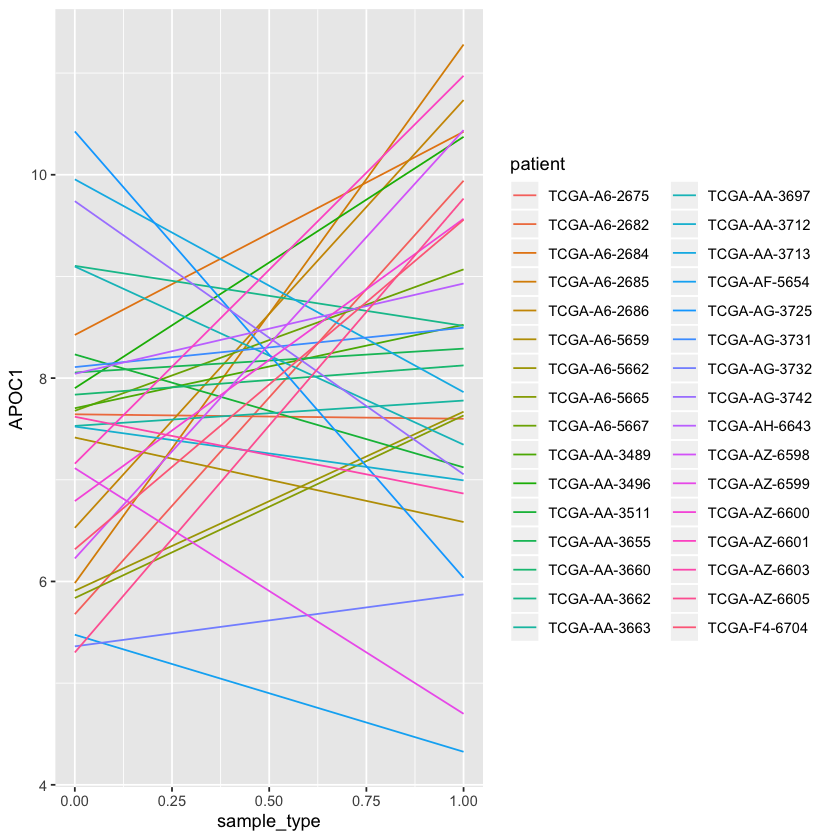

In [585]:
ggplot(data = type, mapping = aes(x = sample_type, y = APOC1, colour = patient)) + geom_line()


##### 生存分析

In [592]:
survival_table=as.data.frame(read.csv('COADREAD_survival.csv',header = T))

In [594]:
rownames(survival_table)=survival_table$sample

In [595]:
#信息矩阵制作
meta = na.omit(survival_table[tumor,1:4])
meta = meta[,-2]
colnames(meta) = c('ID','event',"time")

meta$time_m = meta$time/30
dat = expset[,as.character(meta$ID)]

In [596]:
a = dat['APOC1',]
c = apply(a,1,mean)
b = ifelse(t(a)[,1]>c,1,0)
meta$up_APOC1 = b

Call: survfit(formula = Surv(time, event) ~ up_APOC1, data = meta)

             n events median 0.95LCL 0.95UCL
up_APOC1=0 188     34     NA    2475      NA
up_APOC1=1 188     51   2047    1661      NA

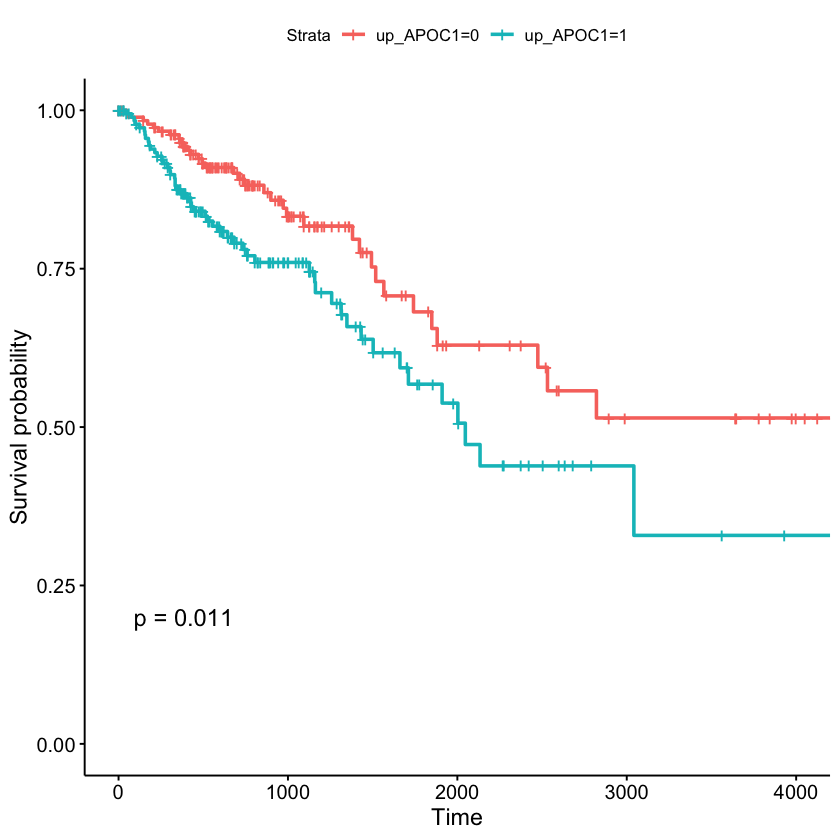

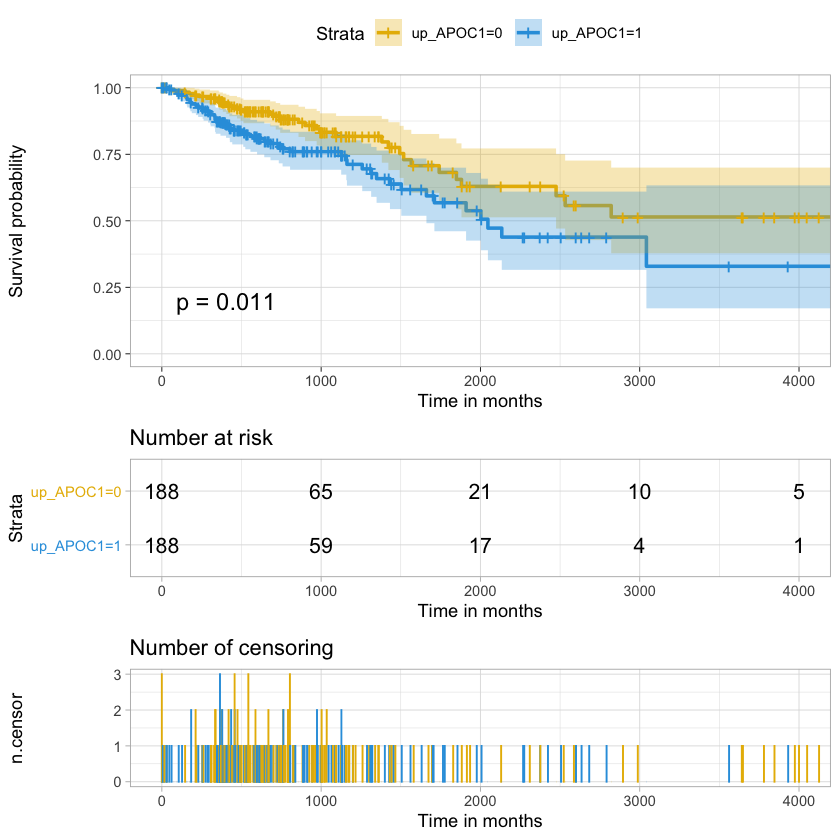

In [597]:
sfit <- survfit(Surv(time, event)~up_APOC1, data=meta)
sfit
ggsurvplot(sfit, conf.int=F, pval=TRUE)
## more complicate figures.
ggsurvplot(sfit,palette = c("#E7B800", "#2E9FDF"),
           risk.table =TRUE,pval =TRUE,
           conf.int =TRUE,xlab ="Time in months", 
           ggtheme =theme_light(), 
           ncensor.plot = TRUE)

Call: survfit(formula = Surv(time_m, event) ~ up_APOC1, data = meta)

             n events median 0.95LCL 0.95UCL
up_APOC1=0 188     34     NA    82.5      NA
up_APOC1=1 188     51   68.2    55.4      NA

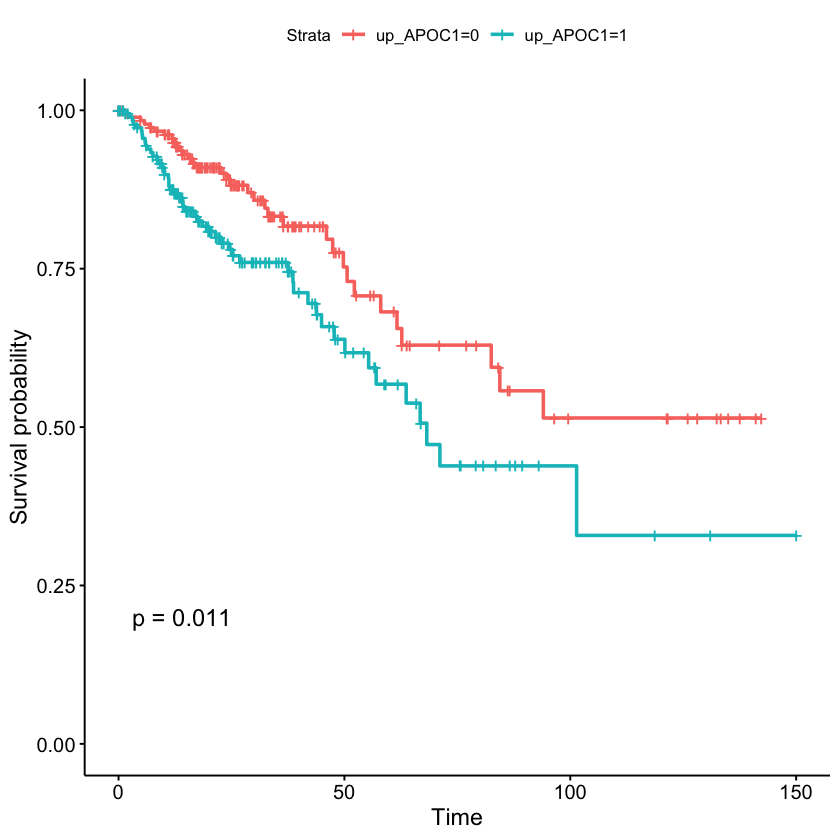

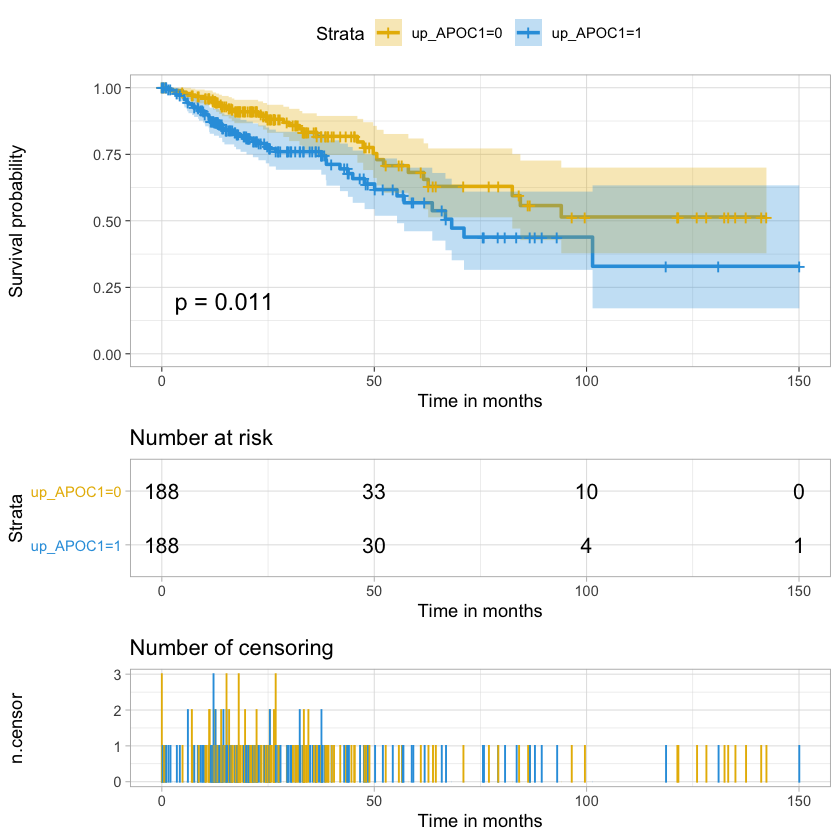

In [598]:
sfit <- survfit(Surv(time_m, event)~up_APOC1, data=meta)
sfit
ggsurvplot(sfit, conf.int=F, pval=TRUE)
## more complicate figures.
ggsurvplot(sfit,palette = c("#E7B800", "#2E9FDF"),
           risk.table =TRUE,pval =TRUE,
           conf.int =TRUE,xlab ="Time in months", 
           ggtheme =theme_light(), 
           ncensor.plot = TRUE)

##### 分开是分开了，但是并没有文章中的那样显著

##### 而且不知道为什么我的样本比文章中的多

In [670]:
save(clinic,dat,file='step1-output.Rdata')

In [714]:
deg

,logFC,AveExpr,t,P.Value,adj.P.Val,B,g,symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CDH3,6.247058,10.0243842,44.46168,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006429723,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001320022,361.6275,UP,CDH3
OTOP2,-9.367759,1.9088174,-44.32969,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000018373693,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001886060,360.5861,DOWN,OTOP2
AADACL2,-2.715070,0.4018283,-41.26910,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001221240260122650756,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000083573541801060062,335.8567,DOWN,AADACL2
KRT80,6.612054,8.6982102,39.09479,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000118079850736016012356912434,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000006060448339026021892942039,317.5952,UP,KRT80
DHRS7C,-2.841467,0.4441800,-39.05110,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000171885964070947853432187579,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000007057637684753118616106286,317.2222,DOWN,DHRS7C
OTOP3,-4.492609,0.7197856,-38.74390,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002423773415299807124256446608,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000082933447026841726274763594,314.5930,DOWN,OTOP3
ETV4,5.465516,10.3992213,37.80825,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000008244426204706680488411357827137,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000241797242832325927378762749246,306.5120,UP,ETV4
ESM1,5.535565,6.5269056,34.62283,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000019778373639817904558794454253515317155243654,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000507562513531826969409251702005211196146556,278.1688,UP,ESM1
LGI1,-4.635610,1.1558425,-34.29387,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000403777604917831204117992632891645026718488444,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000009210615809958972197143952186407847041584016,275.1684,DOWN,LGI1


## GSEA


##### GSEA全称为Gene Set Enrichment Analysis

In [7]:
dir()
d='/Volumes/Lexar/生信技能树学徒作业/TCGA/msigdb_v7.0_files_to_download_locally/msigdb_v7.0_GMTs/symbols/'
DEG=as.data.frame(read.csv('deg.csv',header = T, row.names = 1))

[1] "学徒作业_TCGA"                        
 [2] "学徒作业_TCGA.html"                   
 [3] "学徒作业_TCGA.ipynb"                  
 [4] "学徒作业_TCGA.zip"                    
 [5] "all_samples_PCA.png"                  
 [6] "anno_DEG.Rdata"                       
 [7] "clinic.csv"                           
 [8] "COADREAD_clinic.csv"                  
 [9] "COADREAD_clinic.txt"                  
[10] "COADREAD_exp.txt"                     
[11] "COADREAD_survival.csv"                
[12] "COADREAD_survival.txt"                
[13] "coding.csv"                           
[14] "cor_all.png"                          
[15] "cor_top500.png"                       
[16] "deg.csv"                              
[17] "gsea_results.Rdata"                   
[18] "heatmap_top200_DEG.png"               
[19] "kegg_and_go_up_and_down.R"            
[20] "MA.png"                               
[21] "msigdb_v7.0_files_to_download_locally"
[22] "msigdb.v7.0.symbols.gmt"              
[23] "step1-output.Rdata"                   
[24] "volcano.png"

In [17]:
DEG$symbol=rownames(DEG)
head(DEG)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CDH3,6.247058,10.0243842,44.46168,6.429723e-163,1.320022e-158,361.6275,CDH3
OTOP2,-9.367759,1.9088174,-44.32969,1.837369e-162,1.886060e-158,360.5861,OTOP2
AADACL2,-2.715070,0.4018283,-41.26910,1.221240e-151,8.357354e-148,335.8567,AADACL2
KRT80,6.612054,8.6982102,39.09479,1.180799e-143,6.060448e-140,317.5952,KRT80
DHRS7C,-2.841467,0.4441800,-39.05110,1.718860e-143,7.057638e-140,317.2222,DHRS7C
OTOP3,-4.492609,0.7197856,-38.74390,2.423773e-142,8.293345e-139,314.5930,OTOP3


In [18]:
geneList=DEG$logFC
names(geneList)=DEG$symbol
geneList=sort(geneList,decreasing = T)
gmts=list.files(d,pattern = 'all')
gmts

[1] "c1.all.v7.0.symbols.gmt" "c2.all.v7.0.symbols.gmt"
[3] "c3.all.v7.0.symbols.gmt" "c4.all.v7.0.symbols.gmt"
[5] "c5.all.v7.0.symbols.gmt" "c6.all.v7.0.symbols.gmt"
[7] "c7.all.v7.0.symbols.gmt" "h.all.v7.0.symbols.gmt"

In [19]:
library(GSEABase)
gsea_results <- lapply(gmts, function(gmtfile){
    filepath=paste0(d,gmtfile)
    geneset <- read.gmt(filepath)
    print(paste0('Now process the ',gmtfile))
    egmt <- GSEA(geneList, TERM2GENE=geneset, verbose=FALSE)
    return(egmt)
     })

[1] "Now process the c1.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
no term enriched under specific pvalueCutoff...



[1] "Now process the c2.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Now process the c3.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Now process the c4.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


[1] "Now process the c5.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Now process the c6.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Now process the c7.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "Now process the h.all.v7.0.symbols.gmt"


Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.12% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [20]:
gsea_results_list<- lapply(gsea_results, function(x){
   cat(paste(dim(x@result)),'\n')
  x@result})

0 8 
162 11 
106 11 
313 11 
406 11 
40 11 
144 11 
25 11 


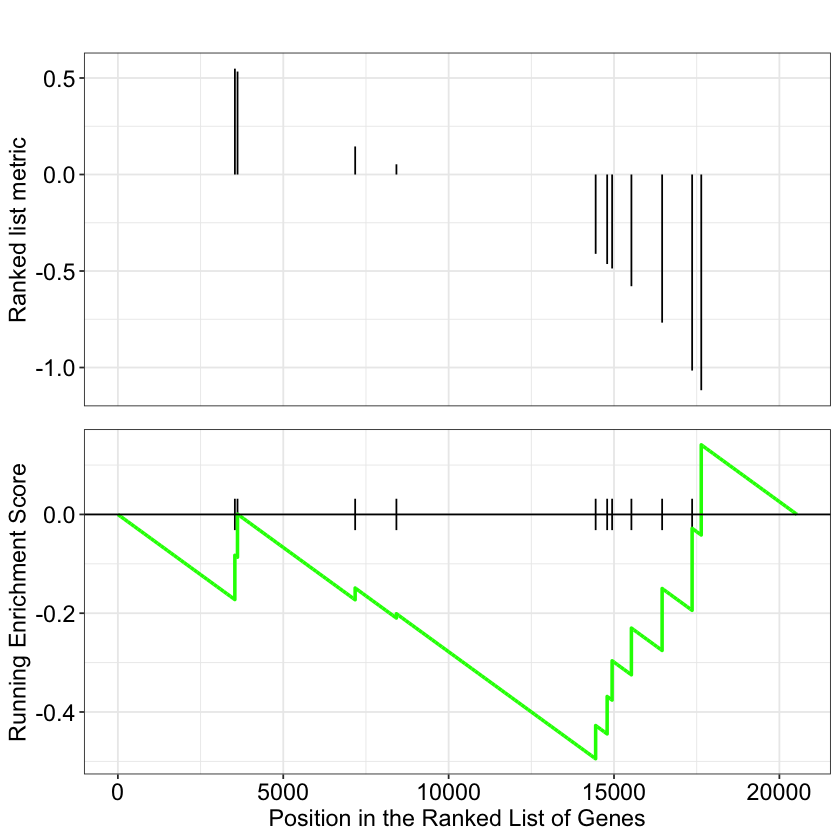

In [23]:
gseaplot(gsea_results[[2]],geneSetID = "NIKOLSKY_BREAST_CANCER_7P15_AMPLICON")

In [ ]:

kk=gseKEGG(
  geneList,
  organism = "hsa",
  keyType = "kegg",
  exponent = 1,
  nPerm = 1000,
  minGSSize = 120,
  maxGSSize = 500,
  pvalueCutoff = 0.05,
  pAdjustMethod = "BH",
  verbose = FALSE,
  use_internal_data = FALSE,
  seed = FALSE,
  by = "fgsea"
)

In [ ]:
gseaplot(kk,geneSetID = 1,title=kk$Description[1] )